In [146]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats.mstats 
from scipy.stats import norm

T = 5
Ta = 0.5
S0 = 2450
K =2450
r = 0.0091
sigma = 0.135
y = 0.0195
def AC_BBMC(T,Ta,m,n,S0,K,r,sigma,y):
    np.random.seed(10)
    mu = r - y - 0.5*pow(sigma,2)
    payoff = np.zeros(n)
    for i in range(n):
        S = np.zeros(m)
        x = np.random.normal(size=m)
        t = Ta/m
        S[0] = S0 * np.exp(mu*(T-Ta+t)+sigma*np.sqrt(T-Ta+t)*x[0])
        for j in range(1,m):
            S[j] = S[j-1] * np.exp(mu*t+sigma*np.sqrt(t)*x[j]) 
        AT = S.mean()
        payoff[i] = 100*max(AT/K-1,0)*np.exp(-T*r)
    return payoff.mean(), payoff.std()/np.sqrt(n)

In [147]:
#m = np.arange(2,202,10)
m = [1,2,6,24,120]
n = 1000
AC_value = np.zeros(len(m))
Std_error_1k = np.zeros(len(m))
i = 0
for m_ in m:
    AC_value[i],Std_error_1k[i] = AC_BBMC(T,Ta,m_,n,S0,K,r,sigma,y)
    i += 1

In [150]:
print('estimated value: ',AC_value)
print('standard error: ',Std_error_1k)


estimated value:  [ 7.75958058  8.00353532  8.45070015  9.19069971  8.63081982]
standard error:  [ 0.50310685  0.49347379  0.52999458  0.54030332  0.51290409]


In [151]:
n = 10000
AC_value = np.zeros(len(m))
Std_error_10k = np.zeros(len(m))
i = 0
for m_ in m:
    AC_value[i],Std_error_10k[i] = AC_BBMC(T,Ta,m_,n,S0,K,r,sigma,y)
    i += 1
print('estimated value: ',AC_value)
print('standard error: ',Std_error_10k)

estimated value:  [ 8.77214549  8.76302927  8.73185601  8.74609128  8.47425943]
standard error:  [ 0.17256786  0.1703988   0.17143375  0.17016715  0.16964077]


In [152]:
n = 100000
AC_value = np.zeros(len(m))
Std_error_100k = np.zeros(len(m))
i = 0
for m_ in m:
    AC_value[i],Std_error_100k[i] = AC_BBMC(T,Ta,m_,n,S0,K,r,sigma,y)
    i += 1
print('estimated value: ',AC_value)
print('standard error: ',Std_error_100k)

estimated value:  [ 8.8508995   8.73370533  8.72811838  8.6052651   8.51762778]
standard error:  [ 0.05541099  0.05442749  0.05404064  0.05350337  0.05316595]


In [153]:
n = 1000000
AC_value = np.zeros(len(m))
Std_error_1000k = np.zeros(len(m))
i = 0
for m_ in m:
    AC_value[i],Std_error_100k[i] = AC_BBMC(T,Ta,m_,n,S0,K,r,sigma,y)
    i += 1
print('estimated value: ',AC_value)
print('standard error: ',Std_error_100k)

estimated value:  [ 8.90650536  8.73797852  8.68121874  8.66891953  8.66288835]
standard error:  [ 0.01763662  0.01721941  0.01705124  0.01699148  0.01698418]


### C


In [119]:
def BSC(S,K,T,r,y,sigma):
    d1 = (np.log(S/K) + (r-y)*T)/(sigma*np.sqrt(T))+sigma*np.sqrt(T)/2
    d2 = d1 - sigma*np.sqrt(T)
    Call = S*np.exp(-y*T)*norm.cdf(d1) -  K*np.exp(-r*T)*norm.cdf(d2)
    return Call

def AC_GCCV(T,Ta,m,n,S0,K,r,sigma,y,beta,EC):
    mu = r - y - 0.5*pow(sigma,2)
    payoff = np.zeros(n)
    ACT_list = np.zeros(n)
    GCT_list = np.zeros(n)
    for i in range(n):
        S = np.zeros(m)
        x = np.random.normal(size=m)
        t = Ta/m
        S[0] = S0 * np.exp(mu*(T-Ta+t)+sigma*np.sqrt(T-Ta+t)*x[0])
        for j in range(1,m):
            S[j] = S[j-1] * np.exp(mu*t+sigma*np.sqrt(t)*x[j]) 
        ACT_list[i] = 100*max((S.mean()-K)/S0,0) * np.exp(-T*r)  
        GCT_list[i] = 100*max((scipy.stats.mstats.gmean(S)-K)/S0,0) * np.exp(-T*r)  
    EACT = beta * EC + np.sum((ACT_list - beta * GCT_list))/n
    std_error = (beta * EC + (ACT_list - beta * GCT_list)).std()/np.sqrt(n)
    return EACT, ACT_list, GCT_list, std_error

In [120]:
m = 120
mu_g = (r-y-pow(sigma,2)/2)*((T-Ta)*m+Ta/m*(1+m)*m/2)/m

sigma2_g = pow(sigma,2)*(T-Ta+Ta/m)*(m+(1+m)*m/2)
for i in range(2,m):
    sigma2_g += pow(sigma,2)*(T-Ta+i*Ta/m)*(m-i)
sigma2_g = sigma2_g / pow(m,2)
F_G_T =S0*np.exp(mu_g+sigma2_g/2)
sigma_eff = np.sqrt(sigma2_g/T)
EC_g = 100*BSC(F_G_T/K,1,T,r,r,sigma_eff)

n = 1000
EACT, ACT_list, GCT_list,std_error = AC_GCCV(T,Ta,m,n,S0,K,r,sigma,y,1,EC_g)
beta_ = np.cov(ACT_list, GCT_list)[0,1] /np.var(GCT_list)
EACT_,tmp1,tmp2,std_error = AC_GCCV(T,Ta,m,n,S0,K,r,sigma,y,beta_,EC_g)
print('n = 1000, Geometric average control variates estimation = ', EACT_)
print('--------- Optimal beta = ', beta_, '; standard error = ', std_error)

n = 10000
EACT, ACT_list, GCT_list,std_error = AC_GCCV(T,Ta,m,n,S0,K,r,sigma,y,1,EC_g)
beta_ = np.cov(ACT_list, GCT_list)[0,1] /np.var(GCT_list)
EACT_,tmp1,tmp2,std_error = AC_GCCV(T,Ta,m,n,S0,K,r,sigma,y,beta_,EC_g)
print('n = 10000, Geometric average control variates estimation = ', EACT_)
print('--------- Optimal beta = ', beta_, '; standard error = ', std_error)

n = 100000
EACT, ACT_list, GCT_list,std_error = AC_GCCV(T,Ta,m,n,S0,K,r,sigma,y,1,EC_g)
beta_ = np.cov(ACT_list, GCT_list)[0,1] /np.var(GCT_list)
EACT_,tmp1,tmp2,std_error = AC_GCCV(T,Ta,m,n,S0,K,r,sigma,y,beta_,EC_g)
print('n = 100000, Geometric average control variates estimation = ', EACT_)
print('--------- Optimal beta = ', beta_, '; standard error = ', std_error)

n = 1000, Geometric average control variates estimation =  8.53749775717
--------- Optimal beta =  1.00307485609 ; standard error =  0.00196399744654
n = 10000, Geometric average control variates estimation =  8.53420126034
--------- Optimal beta =  1.00223751452 ; standard error =  0.000568668232531
n = 100000, Geometric average control variates estimation =  8.53470614946
--------- Optimal beta =  1.00218570003 ; standard error =  0.000179569068151


In [121]:
def AC_ECCV(T,Ta,m,n,S0,K,r,sigma,y,beta,EC):
    mu = r - y - 0.5*pow(sigma,2)
    payoff = np.zeros(n)
    ACT_list = np.zeros(n)
    ECT_list = np.zeros(n)
    for i in range(n):
        S = np.zeros(m)
        x = np.random.normal(size=m)
        t = Ta/m
        S[0] = S0 * np.exp(mu*(T-Ta+t)+sigma*np.sqrt(T-Ta+t)*x[0])
        for j in range(1,m):
            S[j] = S[j-1] * np.exp(mu*t+sigma*np.sqrt(t)*x[j]) 
        ACT_list[i] = 100*max((S.mean()-K)/S0,0) * np.exp(-T*r)  
        ECT_list[i] = 100*max((S[-1]-K)/S0,0) * np.exp(-T*r)  
    EACT = beta * EC + np.sum((ACT_list - beta * ECT_list))/n
    std_error = (beta * EC + (ACT_list - beta * ECT_list)).std()/np.sqrt(n)
    return EACT, ACT_list, ECT_list, std_error

In [122]:
m = 120
EC_E = 100*BSC(S0/K,1,T,r,y,sigma)

n = 1000
EACT, ACT_list, ECT_list, std_error = AC_ECCV(T,Ta,m,n,S0,K,r,sigma,y,1,EC_E)
beta_ = np.cov(ACT_list, ECT_list)[0,1] /np.var(ECT_list)
EACT_,tmp1,tmp2, std_error = AC_ECCV(T,Ta,m,n,S0,K,r,sigma,y,beta_,EC_E)
print('n = 1000, European option control variates estimation = ', EACT_)
print('--------- Optimal beta = ', beta_, '; standard error = ', std_error)

n = 10000
EACT, ACT_list, ECT_list, std_error = AC_ECCV(T,Ta,m,n,S0,K,r,sigma,y,1,EC_E)
beta_ = np.cov(ACT_list, ECT_list)[0,1] /np.var(ECT_list)
EACT_,tmp1,tmp2, std_error = AC_ECCV(T,Ta,m,n,S0,K,r,sigma,y,beta_,EC_E)
print('n = 10000, European option control variates estimation = ', EACT_)
print('--------- Optimal beta = ', beta_, '; standard error = ', std_error)

n = 100000
EACT, ACT_list, ECT_list, std_error = AC_ECCV(T,Ta,m,n,S0,K,r,sigma,y,1,EC_E)
beta_ = np.cov(ACT_list, ECT_list)[0,1] /np.var(ECT_list)
EACT_,tmp1,tmp2, std_error = AC_ECCV(T,Ta,m,n,S0,K,r,sigma,y,beta_,EC_E)
print('n = 100000, European option control variates estimation = ', EACT_)
print('--------- Optimal beta = ', beta_, '; standard error = ', std_error)


n = 1000, European option control variates estimation =  8.56859907047
--------- Optimal beta =  0.946745552912 ; standard error =  0.112377223842
n = 10000, European option control variates estimation =  8.63494924883
--------- Optimal beta =  0.939379278477 ; standard error =  0.0389249604701
n = 100000, European option control variates estimation =  8.68114961891
--------- Optimal beta =  0.937735408681 ; standard error =  0.0120228637106


In [123]:
def AC_multiCV(T,Ta,m,n,S0,K,r,sigma,y,betas, ECs):
    beta1, beta2 = betas
    EC_g, EC_E = ECs
    mu = r - y - 0.5*pow(sigma,2)
    payoff = np.zeros(n)
    ACT_list = np.zeros(n)
    ECT_list = np.zeros(n)
    GCT_list = np.zeros(n)
    for i in range(n):
        S = np.zeros(m)
        x = np.random.normal(size=m)
        t = Ta/m
        S[0] = S0 * np.exp(mu*(T-Ta+t)+sigma*np.sqrt(T-Ta+t)*x[0])
        for j in range(1,m):
            S[j] = S[j-1] * np.exp(mu*t+sigma*np.sqrt(t)*x[j]) 
        ACT_list[i] = 100*max((S.mean()-K)/S0,0) * np.exp(-T*r)  
        ECT_list[i] = 100*max((S[-1]-K)/S0,0) * np.exp(-T*r)  
        GCT_list[i] = 100*max((scipy.stats.mstats.gmean(S)-K)/S0,0) * np.exp(-T*r)
    EACT = beta1 * EC_g + beta2 * EC_E + np.sum((ACT_list - beta1 * GCT_list - beta2 * ECT_list))/n
    std_error = (beta1 * EC_g + beta2 * EC_E +(ACT_list - beta1 * GCT_list - beta2 * ECT_list)).std()/np.sqrt(n)
    return EACT, ACT_list, GCT_list, ECT_list, std_error

In [124]:
m = 120

n = 1000
EACT, ACT_list, GCT_list, ECT_list, std_error = AC_multiCV(T,Ta,m,n,S0,K,r,sigma,y,[1,1],[EC_g,EC_E])
cov_ACT_CT = np.matrix([np.cov(ACT_list, GCT_list)[0,1], np.cov(ACT_list, ECT_list)[0,1]]).T
cov_CT_CT = np.matrix(np.cov(ACT_list, ECT_list))
beta_ = cov_CT_CT.I * cov_ACT_CT
EACT_,tmp1,tmp2,tmp3, std_error = AC_multiCV(T,Ta,m,n,S0,K,r,sigma,y,[beta_[0,0],beta_[1,0]],[EC_g,EC_E])
print('n = 1000, Multi control variates estimation = ', EACT_)
print('--------- Optimal beta = ', beta_, '; standard error = ', std_error)

n = 10000
EACT, ACT_list, GCT_list, ECT_list, std_error = AC_multiCV(T,Ta,m,n,S0,K,r,sigma,y,[1,1],[EC_g,EC_E])
cov_ACT_CT = np.matrix([np.cov(ACT_list, GCT_list)[0,1], np.cov(ACT_list, ECT_list)[0,1]]).T
cov_CT_CT = np.matrix(np.cov(ACT_list, ECT_list))
beta_ = cov_CT_CT.I * cov_ACT_CT
EACT_,tmp1,tmp2,tmp3, std_error = AC_multiCV(T,Ta,m,n,S0,K,r,sigma,y,[beta_[0,0],beta_[1,0]],[EC_g,EC_E])
print('n = 10000, Multi option control variates estimation = ', EACT_)
print('--------- Optimal beta = ', beta_, '; standard error = ', std_error)

n = 100000
EACT, ACT_list, GCT_list, ECT_list, std_error = AC_multiCV(T,Ta,m,n,S0,K,r,sigma,y,[1,1],[EC_g,EC_E])
cov_ACT_CT = np.matrix([np.cov(ACT_list, GCT_list)[0,1], np.cov(ACT_list, ECT_list)[0,1]]).T
cov_CT_CT = np.matrix(np.cov(ACT_list, ECT_list))
beta_ = cov_CT_CT.I * cov_ACT_CT
EACT_,tmp1,tmp2,tmp3, std_error = AC_multiCV(T,Ta,m,n,S0,K,r,sigma,y,[beta_[0,0],beta_[1,0]],[EC_g,EC_E])
print('n = 100000, Multi option control variates estimation = ', EACT_)
print('--------- Optimal beta = ', beta_, '; standard error = ', std_error)

n = 1000, Multi control variates estimation =  8.54788976742
--------- Optimal beta =  [[ 0.95820188]
 [ 0.03917803]] ; standard error =  0.00558219546639
n = 10000, Multi option control variates estimation =  8.53823904551
--------- Optimal beta =  [[ 0.95753388]
 [ 0.04004682]] ; standard error =  0.00174967343204
n = 100000, Multi option control variates estimation =  8.53976420153
--------- Optimal beta =  [[ 0.95718   ]
 [ 0.04025739]] ; standard error =  0.000559568037964


### D

In [131]:
def Product_BBMC(T,Ta,m,n,S0,K,r,sigma,y):
    option_value, tmp = AC_BBMC(T,Ta,m,n,S0,K,r,sigma,y)
    mu = r - y - 0.5*pow(sigma,2)
    x = np.random.normal(size=n)
    capital_gain = np.zeros(n)
    for i in range(n):
        ST = S0 * np.exp(mu*T+sigma*np.sqrt(T)*x[0])
        capital_gain[i] = 1+max(ST/S0-1,0)*1.05
    return option_value + 100*capital_gain.mean()*np.exp(-r*T)
        
print('n=1000, product value = ', Product_BBMC(T,Ta,120,1000,S0,K,r,sigma,y))
print('n=10000, product value = ', Product_BBMC(T,Ta,120,10000,S0,K,r,sigma,y))
print('n=100000, product value = ', Product_BBMC(T,Ta,120,100000,S0,K,r,sigma,y))

n=1000, product value =  104.18278008
n=10000, product value =  104.026219683
n=100000, product value =  104.069588036


### E

iii

In [157]:
m = 120
eps = 0.001

S = np.arange(S0*0.9,S0*1.1,20)
Delta_1000 = np.zeros(len(S))
Delta_10000 = np.zeros(len(S))
Delta_100000 = np.zeros(len(S))
i=0
for S_ in S:
    S_p = (1+eps)*S_
    S_m = (1-eps)*S_
    
    C_p = AC_BBMC(T,Ta,m,1000,S_p,K,r,sigma,y)[0]
    C_m = AC_BBMC(T,Ta,m,1000,S_m,K,r,sigma,y)[0]
    Delta_1000[i] = (C_p - C_m) / (2*100*eps*S0/K)
    
    C_p = AC_BBMC(T,Ta,m,10000,S_p,K,r,sigma,y)[0]
    C_m = AC_BBMC(T,Ta,m,10000,S_m,K,r,sigma,y)[0]
    Delta_10000[i] = (C_p - C_m) / (2*100*eps*S0/K)
    
    C_p = AC_BBMC(T,Ta,m,100000,S_p,K,r,sigma,y)[0]
    C_m = AC_BBMC(T,Ta,m,100000,S_m,K,r,sigma,y)[0]
    Delta_100000[i] = (C_p - C_m) / (2*100*eps*S0/K)
    print(i)
    i+=1
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


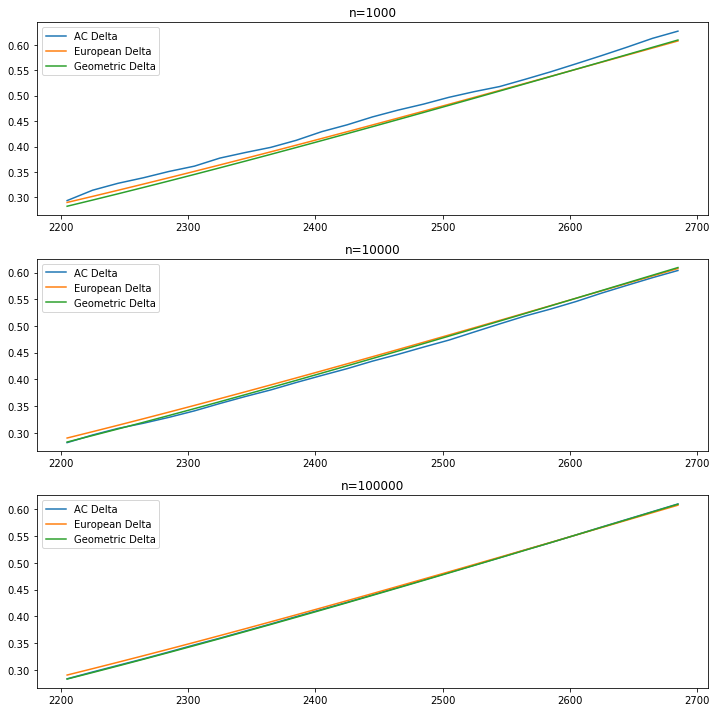

In [172]:
EuroCall_Delta = np.zeros(len(S))
GeoAsianCall_Delta = np.zeros(len(S))

mu_g = (r-y-pow(sigma,2)/2)*((T-Ta)*m+Ta/m*(1+m)*m/2)/m
sigma2_g = pow(sigma,2)*(T-Ta+Ta/m)*(m+(1+m)*m/2)
for i in range(2,m):
    sigma2_g += pow(sigma,2)*(T-Ta+i*Ta/m)*(m-i)
sigma2_g = sigma2_g / pow(m,2)
sigma_eff = np.sqrt(sigma2_g/T)
i =0
for S_ in S:
    S_p = (1+eps)*S_
    S_m = (1-eps)*S_
    
    C_p = 100*BSC(S_p/K,1,T,r,y,sigma)
    C_m = 100*BSC(S_m/K,1,T,r,y,sigma)
    EuroCall_Delta[i] = (C_p - C_m) / (2*100*eps*S0/K)
    
    F_p =S_p*np.exp(mu_g+sigma2_g/2)
    F_m =S_m*np.exp(mu_g+sigma2_g/2)
    C_p =100*BSC(F_p/K,1,T,r,r,sigma_eff)
    C_m =100*BSC(F_m/K,1,T,r,r,sigma_eff)
    GeoAsianCall_Delta[i] = (C_p - C_m) / (2*100*eps*S0/K)
    i+=1
    
plt.figure(figsize=(10,10))
plt.subplot(311)
plt.title('n=1000')
plt.plot(S,Delta_1000,label='AC Delta')
plt.plot(S,EuroCall_Delta,label='European Delta')
plt.plot(S,GeoAsianCall_Delta,label='Geometric Delta')
plt.legend()
plt.subplot(312)
plt.title('n=10000')
plt.plot(S,Delta_10000,label='AC Delta')
plt.plot(S,EuroCall_Delta,label='European Delta')
plt.plot(S,GeoAsianCall_Delta,label='Geometric Delta')
plt.legend()
plt.subplot(313)
plt.title('n=100000')
plt.plot(S,Delta_100000,label='AC Delta')
plt.plot(S,EuroCall_Delta,label='European Delta')
plt.plot(S,GeoAsianCall_Delta,label='Geometric Delta')
plt.legend()
plt.tight_layout()
plt.show()

In [174]:
Vega_1000 = np.zeros(len(S))
Vega_10000 = np.zeros(len(S))
Vega_100000 = np.zeros(len(S))
i=0
for S_ in S:
    sigma_p = (1+eps)*sigma
    sigma_m = (1-eps)*sigma
    
    C_p = AC_BBMC(T,Ta,m,1000,S_,K,r,sigma_p,y)[0]
    C_m = AC_BBMC(T,Ta,m,1000,S_,K,r,sigma_m,y)[0]
    Vega_1000[i] = (C_p - C_m) / (2*eps*sigma)
    
    C_p = AC_BBMC(T,Ta,m,10000,S_,K,r,sigma_p,y)[0]
    C_m = AC_BBMC(T,Ta,m,10000,S_,K,r,sigma_m,y)[0]
    Vega_10000[i] = (C_p - C_m) / (2*eps*sigma)
    
    C_p = AC_BBMC(T,Ta,m,100000,S_,K,r,sigma_p,y)[0]
    C_m = AC_BBMC(T,Ta,m,100000,S_,K,r,sigma_m,y)[0]
    Vega_100000[i] = (C_p - C_m) / (2*eps*S0/K)
    print(i, C_p, C_m, (C_p - C_m) / (2*eps*sigma) )
    i+=1

0 4.72937440499 4.71203285541 64.2279614133
1 4.99095810815 4.97323802874 65.6299237576
2 5.2614324677 5.24336338419 66.9225315223
3 5.54041570394 5.5220155435 68.1487423784
4 5.82790780866 5.80918309603 69.3507875042
5 6.12425082822 6.10521477357 70.5039060981
6 6.42921675479 6.4098932299 71.568610693
7 6.74264506393 6.72304337885 72.59883361
8 7.06458682047 7.04472579066 73.5593696812
9 7.39526773387 7.3751581914 74.4797869243
10 7.73447563926 7.71413816693 75.3239716021
11 8.0819428219 8.06139442201 76.1051847909
12 8.43774991112 8.4170048086 76.8337130372
13 8.80201026882 8.78108547432 77.4992388981
14 9.17440879898 9.15332079526 78.1037174585
15 9.55506029208 9.5338256527 78.6468125209
16 9.94370856201 9.92234283107 79.1323368373
17 10.3400557198 10.3185758522 79.5550651593
18 10.7445069832 10.722931109 79.9106449573
19 11.1567267909 11.1350641646 80.2319491854
20 11.5765715073 11.5548450942 80.4681969516
21 12.0043731683 11.9826019315 80.6342101429
22 12.439918969 12.4181155374 8

In [181]:
EuroCall_Vega = np.zeros(len(S))
GeoAsianCall_Vega = np.zeros(len(S))

mu_g = (r-y-pow(sigma,2)/2)*((T-Ta)*m+Ta/m*(1+m)*m/2)/m

j =0
for S_ in S:
    sigma_p = (1+eps)*sigma
    Sigma_m = (1-eps)*sigma
    
    C_p = 100*BSC(S_/K,1,T,r,y,sigma_p)
    C_m = 100*BSC(S_/K,1,T,r,y,sigma_m)
    EuroCall_Vega[j] = (C_p - C_m) / (2*eps*sigma)
    
    sigma2_g_p = pow(sigma_p,2)*(T-Ta+Ta/m)*(m+(1+m)*m/2)
    for i in range(2,m):
        sigma2_g_p += pow(sigma_p,2)*(T-Ta+i*Ta/m)*(m-i)
    sigma2_g_p = sigma2_g_p / pow(m,2)
    sigma_eff_p = np.sqrt(sigma2_g_p/T)
    F_p =S_*np.exp(mu_g+sigma2_g_p/2)
    C_p =100*BSC(F_p/K,1,T,r,r,sigma_eff_p)
    
    sigma2_g_m = pow(sigma_m,2)*(T-Ta+Ta/m)*(m+(1+m)*m/2)
    for i in range(2,m):
        sigma2_g_m += pow(sigma_m,2)*(T-Ta+i*Ta/m)*(m-i)
    sigma2_g_m = sigma2_g_m / pow(m,2)
    sigma_eff_m = np.sqrt(sigma2_g_m/T)
    F_m =S_*np.exp(mu_g+sigma2_g_m/2)
    C_m =100*BSC(F_m/K,1,T,r,r,sigma_eff_m)
    
    GeoAsianCall_Vega[j] = (C_p - C_m) / (2*eps*sigma)
    j+=1

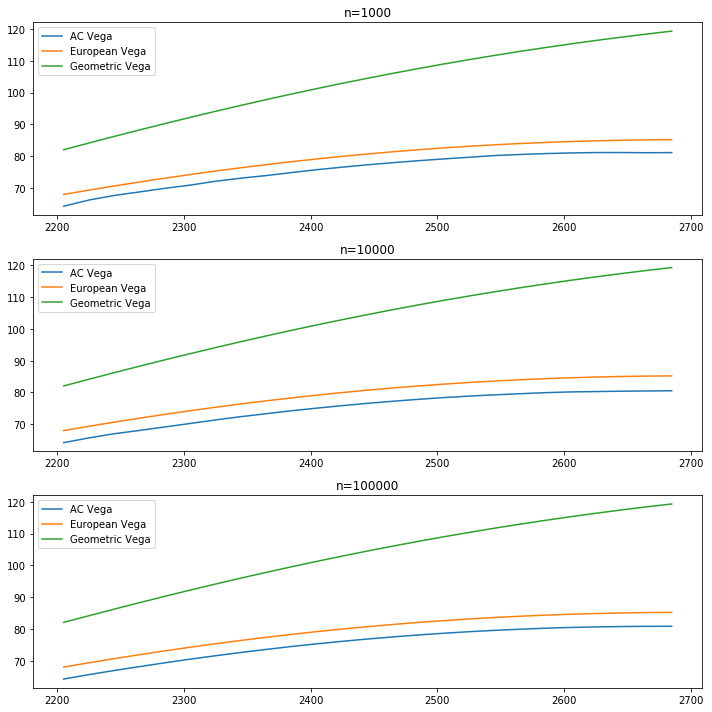

In [184]:
#Vega_100000[i] = (C_p - C_m) / (2*eps*S0/K)

Vega_100000_ = Vega_100000 * (S0/K) /   sigma 

plt.figure(figsize=(10,10))
plt.subplot(311)
plt.title('n=1000')
plt.plot(S,Vega_1000,label='AC Vega')
plt.plot(S,EuroCall_Vega,label='European Vega')
plt.plot(S,GeoAsianCall_Vega,label='Geometric Vega')
plt.legend()
plt.subplot(312)
plt.title('n=10000')
plt.plot(S,Vega_10000,label='AC Vega')
plt.plot(S,EuroCall_Vega,label='European Vega')
plt.plot(S,GeoAsianCall_Vega,label='Geometric Vega')
plt.legend()
plt.subplot(313)
plt.title('n=100000')
plt.plot(S,Vega_100000_,label='AC Vega')
plt.plot(S,EuroCall_Vega,label='European Vega')
plt.plot(S,GeoAsianCall_Vega,label='Geometric Vega')
plt.legend()
plt.tight_layout()
plt.show()

### Question 4

In [ ]:
from scipy.integrate import quad
import statsmodels.api as sm

S_0 = K = 2450
T= 1
r = 91/10000
y = 0.0195
sigma = 0.135
# number of scenarios 
n = 10000
#n_t =100

def cholesky(l,p):
    ## generate rho
    I = np.identity(l)
    A = p*np.ones((l,l))
    rho = (1-p)*I+A
    return np.linalg.cholesky(rho)

def generate_CT(l,n,L,S_0,K,T,r,y,sigma):
    S_T = np.zeros((n,l))
    C_T = np.zeros(n)
    for i in range(n):
        #S_new = S_0
        #for t in range(n_t):
        zk_ =np.transpose(np.random.normal(0,1,l))
        xk = np.dot(L,zk_)
        S_T[i,:] = S_0*np.exp((r-y-sigma**2/2)*T+sigma*np.sqrt(T)*xk)
        #S_new = S_T[i,:]
        #print(S_T[i,:])
        C_T[i] = max(max(S_T[i,:])-K,0)
    return C_T

## compute value
def C_t(l,n,p,S_0,K,T,r,y,sigma):
    L = cholesky(l,p)
    C_T = generate_CT(l,n,L,S_0,K,T,r,y,sigma)
    return np.exp(-r*T)*np.mean(C_T),np.std(C_T)/np.sqrt(n)


i check(a)ii

In [ ]:
def vanilla_call(S_0,K,r,y,sigma,T):
    xp = (np.log(S_0/K)+(r-y)*T)/(sigma*np.sqrt(T))+(sigma*np.sqrt(T))/2
    xm = (np.log(S_0/K)+(r-y)*T)/(sigma*np.sqrt(T))-(sigma*np.sqrt(T))/2
    return S_0*np.exp(-y*T)*norm.cdf(xp)-K*np.exp(-r*T)*norm.cdf(xm)
C_V=vanilla_call(S_0,K,r,y,sigma,T)
for l in [1,2,5,10,20,50]:
    for n in [1000,10000,100000]:
        print("When l =  %s n=  %d" %(l,n))
        C = C_t(l,n,0.999999999999999,S_0,K,T,r,y,sigma)
        print(C, C[0]-C_V)

In [175]:
#### check(a)iii

In [ ]:
def close_form(x, l):
    A = (r-y-sigma**2/2.)*T
    B = np.sqrt(sigma**2*T)
    return (S_0*np.exp(A+B*x)-K)*l*norm.pdf(x)*np.power(norm.cdf(x),l-1)

for l in [1,2,5,10,20,50]:
    for n in [1000,10000,100000]:
        print("When l =  %s n=  %d" %(l,n))
        C_V = np.exp(-r*T)*quad(close_form,0,np.inf,args=(l))[0]
        C = C_t(l,n,0,S_0,K,T,r,y,sigma)
        print(C, C[0]-C_V)

(ii)

In [ ]:
for p in [0,0.25,0.5,0.75,0.9]:
    for l in [1,2,5,10,20,50]:
        for n in [1000,10000,100000]:
            print("When p = %s l =  %d n=  %d" %(p,l,n))
            C = C_t(l,n,0,S_0,K,T,r,y,sigma)
            print(C)
            


iii

In [ ]:
for p in [0, 0.25, 0.5, 0.75, 0.9, 0.99]:
    Y= np.zeros(7)
    X = np.zeros(7)
    l = [1,2,5,10,20,50]
    for i in range(len(l)):
        Y[i] = C_t(l[i],n,p,S_0,K,T,r,y,sigma)[0]
        X[i] = np.sqrt(i)-1
    X = sm.add_constant(X)
    results = sm.OLS(Y, X).fit()
    print('When p = ', p)
    print("c0 and c1 is %s,%s" %( results.params[0], results.params[1]))
    print('R^2 = %.4f' % results.rsquared_adj)
    print('pvalue = %.4f' % results.pvalues[1])

C (2) (ii)

In [ ]:
def anti_variates(l,n,p,S_0,K,T,r,y,sigma):
    L = cholesky(l,p)
    S_T = np.zeros((n,l))
    S_T_anti = np.zeros((n,l))
    C_T = np.zeros(n)
    C_T_anti = np.zeros(n)
    for i in range(n):
        zk_ =np.transpose(np.random.normal(0,1,l))
        xk = np.dot(L,zk_)
        S_T[i,:] = S_0*np.exp((r-y-sigma**2/2)*T+sigma*np.sqrt(T)*xk)
        S_T_anti[i,:] = S_0*np.exp((r-y-sigma**2/2)*T-sigma*np.sqrt(T)*xk)
        C_T[i] = max(max(S_T[i,:])-K,0)
        C_T_anti[i] = max(max(S_T_anti[i,:])-K,0)
    return np.exp(-r*T)*np.mean(0.5*(C_T+C_T_anti)),np.std(np.hstack((C_T,C_T_anti)))/np.sqrt(2*n)

In [ ]:
import time
p = [0, 0.25, 0.5, 0.75, 0.9, 0.99]
eff = np.zeros((len(l),len(p)))
n = 100000
for i in range(len(l)):
    for j in range(len(p)):
        start = time.time()
        C_bare = C_t(l[i],n,p[j],S_0,K,T,r,y,sigma)[1]
        end = time.time()
        start_anti = time.time()
        C_anti = anti_variates(l[i],n,p[j],S_0,K,T,r,y,sigma)[1]
        end_anti = time.time()
        eff[i,j] = (C_bare**2*(start-end))/(C_anti**2*(start_anti-end_anti))
print(eff)        

In [ ]:
#### Control Variates

In [ ]:
def control_variates_vanilla(l,n,p,S_0,K,T,r,y,sigma):
    L = cholesky(l,p)
    S_T = np.zeros((n,l))
    S_T_anti = np.zeros((n,l))
    S_T_vanilla = np.zeros(n)
    S_T_vanilla_anti = np.zeros(n)
    C_T = np.zeros(n)
    C_T_anti = np.zeros(n)
    C_T_vanilla = np.zeros(n)
    C_T_vanilla_anti = np.zeros(n)
    for i in range(n):
        zk_ =np.transpose(np.random.normal(0,1,l))
        xk = np.dot(L,zk_)
        S_T[i,:] = S_0*np.exp((r-y-sigma**2/2)*T+sigma*np.sqrt(T)*xk)
        S_T_anti[i,:] = S_0*np.exp((r-y-sigma**2/2)*T-sigma*np.sqrt(T)*xk)
        S_T_vanilla[i] = S_0*np.exp((r-y-sigma**2/2)*T+sigma*np.sqrt(T)*zk_[0])
        S_T_vanilla_anti[i] = S_0*np.exp((r-y-sigma**2/2)*T-sigma*np.sqrt(T)*zk_[0])
        C_T[i] = max(max(S_T[i,:])-K,0)
        C_T_anti[i] = max(max(S_T_anti[i,:])-K,0)
        C_T_vanilla[i] = max(S_T_vanilla[i]-K,0)
        C_T_vanilla_anti[i] = max(S_T_vanilla_anti[i]-K,0)
    return vanilla_call(S_0,K,r,y,sigma,T)+np.exp(-r*T)*np.mean(0.5*(C_T+C_T_anti-C_T_vanilla-C_T_vanilla_anti)),np.std(np.hstack((C_T-C_T_vanilla,C_T_anti-C_T_vanilla_anti)))/np.sqrt(2*n)

In [ ]:
p = [0.5,0.6,0.7,0.8,0.9,0.99]
eff = np.zeros((len(l),len(p)))
n = 100000
for i in range(len(l)-1):
    for j in range(len(p)):
        start = time.time()
        C_bare = C_t(l[i+1],n,p[j],S_0,K,T,r,y,sigma)[1]
        end = time.time()
        start_cv = time.time()
        C_cv= control_variates_vanilla(l[i+1],n,p[j],S_0,K,T,r,y,sigma)[1]
        end_cv = time.time()
        eff[i,j] = (C_bare**2*(start-end))/(C_cv**2*(start_cv-end_cv))

In [ ]:
print(eff)

In [ ]:
def anti_variates(l,n,p,S_0,K,T,r,y,sigma):
    L = cholesky(l,p)
    S_T = np.zeros((n,l))
    S_T_anti = np.zeros((n,l))
    S_T_con = np.zeros(n)
    C_T = np.zeros(n)
    C_T_anti = np.zeros(n)
    C_T_con = np.zeros(n)
    for i in range(n):
        zk_ =np.transpose(np.random.normal(0,1,l))
        xk = np.dot(L,zk_)
        S_T[i,:] = S_0*np.exp((r-y-sigma**2/2)*T+sigma*np.sqrt(T)*xk)
        S_T_anti[i,:] = S_0*np.exp((r-y-sigma**2/2)*T-sigma*np.sqrt(T)*xk)
        S_T_con[i] = S_0*np.exp((r-y-sigma**2/2)*T+sigma*np.sqrt(T)*max(zk_))
        C_T[i] = max(max(S_T[i,:])-K,0)
        C_T_anti[i] = max(max(S_T_anti[i,:])-K,0)
        C_T_con[i] = max(S_T_con[i]-K,0)
    return np.exp(-r*T)*quad(close_form,0,np.inf,args=(l))[0]+np.exp(-r*T)*np.mean(0.5*(C_T+C_T_anti)-C_T_con),np.std(np.hstack((C_T-C_T_con,C_T_anti-C_T_con)))/np.sqrt(2*n)



In [ ]:
p = [0.01,0.1,0.2,0.3,0.4,0.5]
eff = np.zeros((len(l)-1,len(p)))
n = 100000
for i in range(len(l)-1):
    for j in range(len(p)):
        start = time.time()
        C_bare = C_t(l[i+1],n,p[j],S_0,K,T,r,y,sigma)[1]
        end = time.time()
        start_cv = time.time()
        C_cv= anti_variates(l[i+1],n,p[j],S_0,K,T,r,y,sigma)[1]
        end_cv = time.time()
        eff[i,j] = (C_bare**2*(start-end))/(C_cv**2*(start_cv-end_cv))

In [ ]:
print(eff)